
<img src="https://www.unad.edu.co/images/footer/logo-unad-acreditacion-min.png" width="780" height="140" align="right"/>

<p align="center">Curso: Proyecto Grado</p>

<p align="center"> Código Curso: </p>

<p align="center"> Grupo:  </p>

 <p align="center">   </p>

 <p align="center">  Presentado por: Juan José García Sánchez </p>

<p align="center"> Código: 203008077</p>

 <p align="center"> Tutor(a): Dayana Alejandra Barrera</p>

 <p align="center"> 09/04/2025 </p>

 <p align="center"> UNIVERSIDAD NACIONAL ABIERTA Y A DISTANCIA - UNAD </p>



# Objetivo General

### Aplicar técnicas de análisis de datos sobre un dataset de la calidad del aire,  con el propósito de identificar factores y patrones de contaminación atmosférica, en la ciudad de Bogotá.

# Objetivos Especificos

### 1.	Identificar variables relevantes para el diagnóstico,  en el estudio de la calidad del aire, a partir de la literatura existente, para su análisis en este trabajo.

### 2.	Realizar una limpieza y preprocesamiento de los datos sobre la calidad del aire, para facilitar el análisis y visualización entre características.

### 3.	Analizar la relación entre la concentración de contaminantes, material particulado, y variables meteorológicas; y su papel en la disminución de la calidad del aire, utilizando métodos estadísticos.

# Importar librerias

In [1]:
from enum import StrEnum
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, chisquare, f_oneway
from data_science_tools.stats import medidas_resumen
from data_science_tools.graficos import heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
formato = "{:.3f}"
pd.options.display.float_format = formato.format

# Limpieza de datos

Cargar datos a un dataframe, realizar una combinación y eliminar los posibles datos nulos.

In [2]:

r_reporte = Path("datasets/reporte_sisaire.csv")

df_reporte = pd.read_csv(r_reporte)


#limpiado de datos, el archivo csv debe estar en el mismo directorio

df_reporte.drop_duplicates(inplace=True)

#Transformar fechas a datetime objects
df_reporte["Fecha inicial"] = pd.to_datetime(df_reporte["Fecha inicial"], format="%Y-%m-%d")

#limpieza hecha para los tres modelos: modelo lineal, logistico, y knn. se elimina la columna "wip"
#df_reporte = df_crudo.dropna(axis=1)

In [3]:
class At(StrEnum):
    est = 'Estacion' 
    f = 'Fecha inicial' 
    años = "años"
   
class Otras(StrEnum):
    h10 = 'HAire10' 
    hh = 'HAire?h'
    nox = 'NOx' 
    so2_tr = 'SO2 TR'
    tempcm = 'TMPR AIR 10CM'
    dirv = 'DViento' 
    h2 = 'HAire2'  
    prec = 'PLiquida' 
    temp10 = 'TAire10'
    temp2 = 'TAire2'
    rad = 'RGlobal' 
    p = 'P'
    
class Var(StrEnum):
    co = 'CO' 
    no = 'NO' 
    no2 = 'NO2' 
    o3 = 'O3'
    pm10 = 'PM10'
    pm2= 'PM2.5'
    so2 = 'SO2' 
    velv = 'VViento' 


In [42]:
df_reporte.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81615 entries, 0 to 81614
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Estacion       81615 non-null  object        
 1   Fecha inicial  81615 non-null  datetime64[ns]
 2   CO             50652 non-null  float64       
 3   DViento        47762 non-null  float64       
 4   HAire10        968 non-null    float64       
 5   HAire2         29890 non-null  float64       
 6   HAire?h        719 non-null    float64       
 7   NO             39402 non-null  float64       
 8   NO2            50834 non-null  float64       
 9   NOx            1867 non-null   float64       
 10  O3             58530 non-null  float64       
 11  PLiquida       43655 non-null  float64       
 12  PM10           73891 non-null  float64       
 13  PM2.5          56728 non-null  float64       
 14  RGlobal        26346 non-null  float64       
 15  SO2            2526

## Diccionario de Datos

Diccionario de datos para las mediciones de la red de monitoreo de la calidad del aire (RMCAB) en Bogota, obtenida mediante la pagina de SISAIRE del IDEAM. los campos clave corresponden al de la Estación y la Fecha inicial. 
Los valores de las concentraciones pueden ser menores a cero debido a errores de las estaciones. 

|Campos | Descripción | Clasificación| Niveles |
|---|---|---|---|
| $Estacion$ | Estación (nombre) donde se realizao la medición | categorica (texto) | 24 valores de estación, representado localidad o una fuente de datos. |
| $Fecha\: inicial$ | fecha del dia de la medición | Categorica | texto con formato año-mes-dia, desde el 2010-01-01 al 2025-03-31 |
| $CO$ | Concentración monoxido de carbono | numerica | número real mayor a cero, en $\mu gm^{-3}$ |
| $NO$ | Concentración monoxido de nitrogeno | numerica | número real mayor a cero, en $\mu gm^{-3}$|
| $NO_2$ | Concentración oxido nitroso | numerica | número real mayor a cero, en $\mu gm^{-3}$ |
| $NO_x$ | Concentración combinada de otro compuestos gaseosos de nitrogeno  | numerica | número real positivo, en $mgm^{-3}$ |
| $O_3$ | Concentración de Ozono | numerica | número real mayor a cero, en $\mu gm^{-3}$ |
| $SO_2$ | Concentración de dioxido de azufre | numerica | número real positivo, en $\mu gm^{-3}$ |
| $SO_2 TR$ | Concentración de azufre total reducido: compuesto de azufre gaseosos conteniendo organosulfuro | numerica | número real positivo, en $\mu gm^{-3}$ |
| $PM_{2.5}$ | Concentración del material particulado de diametro $\le 2.5$ micras | numerica | número real positivo, en $\mu gm^{-3}$ |
| $PM_{10}$ | Concentración del material particulado de diametro a $\le 10$ micras | numerica | número real positivo, en $\mu gm^{-3}$ |
| $R_{global}$ | Radiación solar global | numerica | número real positivo, en $Wh m^{-2}$|
| $D_{Viento}$ | Dirección del viento | numerica | número real positivo, en grados|
| $V_{Viento}$ | Velocidad del viento | numerica | número real positivo, en $ms^{-1}$|
| $Haire_{10}$ | Humedad relativa del aire, medida a $10 m$ | numerica | porcentaje de saturación (%)|
| $Haire_{2}$ | Humedad relativa del aire, medida a $2 m$ | numerica | porcentaje de saturación (%)|
| $Haire_{h}$ | Humedad relativa del aire, medida a altura diferentes de 2 o 10 m | numerica | porcentaje de saturación (%)|
| $Taire_{10}$ | Temperatura del aire, medida a $10 m$ | numerica | grados celsius (°C)|
| $Taire_{2}$ | Temperatura del aire, medida a $2 m$ | numerica | grados celsius (°C)|
| $Taire_{10cm}$ | Temperatura del aire, medida a $10 cm$ | numerica | grados celsius (°C)|
| $P$ | Presón atmosferica | numerica | número real positivo, en mmHg|
| $P_{liquida}$ | nivel de precipitación  | numerica | número real positivo, en mm|

In [5]:
df_reporte.describe()

,Fecha inicial,CO,DViento,HAire10,HAire2,HAire?h,NO,NO2,NOx,O3,...,PM10,PM2.5,RGlobal,SO2,SO2 TR,TAire10,TAire2,TMPR AIR 10CM,VViento,P
count,81615,50652.000,47762.000,968.000,29890.000,719.000,39402.000,50834.000,1867.000,58530.000,...,73891.000,56728.000,26346.000,25262.000,20569.000,3712.000,40031.000,2397.000,48016.000,22630.000
mean,2018-07-06 08:12:35.861054976,393.588,177.078,69.467,66.428,64.020,23.320,24.367,45.307,17.792,...,40.716,17.477,162.319,7.424,2.505,14.683,14.935,15.241,1.675,562.565
min,2010-01-01 00:00:00,0.000,0.000,47.000,0.000,31.125,-2.676,0.150,6.327,0.000,...,-9999.000,0.200,0.000,0.000,0.000,11.258,0.000,11.863,0.000,50.500
25%,2014-07-25 12:00:00,0.891,135.834,63.958,60.833,59.396,9.490,14.513,25.292,9.407,...,23.500,9.500,122.167,2.150,1.106,14.058,14.133,14.592,1.163,562.783
50%,2019-03-05 00:00:00,338.441,174.125,69.146,66.167,63.375,17.669,22.118,40.111,14.839,...,36.230,15.528,156.958,3.852,1.775,14.683,14.913,15.225,1.538,563.667
75%,2022-06-07 00:00:00,659.431,217.458,74.875,71.579,69.380,30.059,32.295,57.061,23.491,...,53.097,23.383,197.250,7.264,3.002,15.300,15.729,15.925,2.013,564.375
max,2025-03-31 00:00:00,5025.540,358.042,90.043,121.000,83.000,646.522,126.747,356.840,154.700,...,1103.000,197.357,504.154,117.520,35.456,18.140,24.250,18.462,6.942,567.221
std,NaN,457.688,54.636,7.649,8.605,6.716,21.084,12.778,28.371,11.506,...,47.783,10.354,55.937,11.064,2.301,0.906,1.233,1.000,0.748,18.849


In [4]:
fecha_max = pd.to_datetime("2025-03-31",  format="%Y-%m-%d")
fecha_antes5 = fecha_max - pd.DateOffset(years=5)
fecha_antes10 = fecha_max - pd.DateOffset(years=10)
fecha_antes15 = fecha_max - pd.DateOffset(years=15)

df_rep5 = df_reporte[df_reporte[At.f] >= fecha_antes5]
df_rep10 = df_reporte[df_reporte[At.f] >= fecha_antes10]
df_rep15 = df_reporte[df_reporte[At.f] >= fecha_antes15]


In [5]:
def obtener_prop_validos(df, año):
    conteo_no_nulos = df.notna().sum()

    conteo_fracc = conteo_no_nulos[2:]/conteo_no_nulos[At.est] * 100

    conteo_fracc = pd.concat([conteo_fracc], axis=1)

    conteo_fracc.reset_index(inplace=True)

    conteo_fracc.rename(columns = {0:"porcentaje", "index":"variable"}, inplace=True)

    conteo_fracc["años"] = f"2025 - {2025 - año}"
    
    return conteo_fracc


df_por_intervalo = (df_rep5, df_rep10, df_rep15)
años = (5, 10, 15)

array_conteo = [obtener_prop_validos(df, año) for df, año in zip(df_por_intervalo, años)]

conteo_fracc = pd.concat(array_conteo)


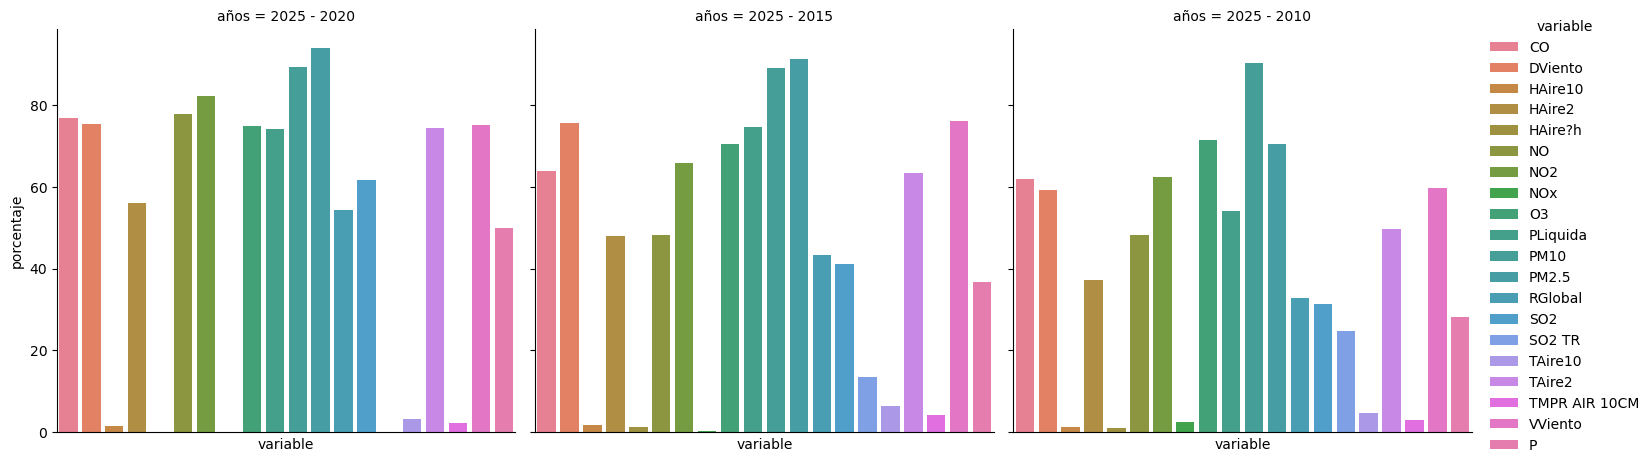

In [7]:
ejes_comp_años = sns.catplot(data=conteo_fracc, x="variable", y="porcentaje", col="años", kind="bar", hue="variable", legend="full")
ejes_comp_años.set(xticks=[])
plt.show()


# Version Final de los datos a 5 años

 el dataframe datos contiene los datos sin index por años, el dataframe datos_año contiene indices  por años para poder acceder a los datos como si fueran agrupados por años

In [8]:
df_rep5[At.años] =  df_rep5[At.f].apply(lambda x: x.year)
variables_eliminar = [var for var in Otras]

datos = df_rep5.drop(variables_eliminar, axis=1)
datos_año = datos.set_index([At.años])

C:\Users\josej\AppData\Local\Temp\ipykernel_14812\201355833.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rep5[At.años] =  df_rep5[At.f].apply(lambda x: x.year)


## Eliminar los registros que tienen valores de pm inconsistentes 

In [9]:
datos = datos[datos[Var.pm10] >= datos[Var.pm2]]

# 1. Analisis Unidimensional

In [10]:
datos_año.index.unique()

Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int64', name='años')

## Medidas de Resumen del dataset años 2020 - 2025

In [11]:
resum = [medidas_resumen(datos, col) for col in Var]
resumen = pd.concat(resum, axis=1)
resumen

,CO,NO,NO2,O3,PM10,PM2.5,SO2,VViento
count,25740.000,26299.000,26642.000,24959.000,30878.000,30878.000,19298.000,24157.000
mean,705.485,21.582,29.323,23.968,32.536,15.884,4.903,1.631
std,387.747,19.949,13.006,11.603,18.072,9.090,4.824,0.737
min,0.254,0.123,0.940,0.000,2.565,0.588,0.058,0.000
25%,453.190,8.854,19.149,15.377,19.288,8.875,2.248,1.142
50%,620.154,16.103,28.201,22.359,29.087,14.469,3.655,1.488
75%,863.445,27.443,38.039,30.648,41.986,21.125,6.066,1.917
max,5025.540,288.814,126.747,114.369,172.368,92.667,117.520,6.942
var,150348.109,397.960,169.162,134.624,326.608,82.623,23.271,0.543


In [12]:
resum = [medidas_resumen(datos_año.loc[2020], col) for col in Var]
resumen = pd.concat(resum, axis=1)
resumen

,CO,NO,NO2,O3,PM10,PM2.5,SO2,VViento
count,2701.000,2847.000,3105.000,3421.000,3758.000,4213.000,2814.000,3636.000
mean,764.670,23.302,28.094,25.327,29.780,14.666,7.753,1.748
std,433.738,20.709,12.578,11.155,18.468,8.832,11.635,0.907
min,0.254,0.123,1.628,0.883,2.565,0.588,0.214,0.250
25%,457.960,8.969,18.686,17.192,16.634,7.729,2.092,1.175
50%,667.858,17.105,26.503,23.953,25.879,12.958,3.562,1.554
75%,967.961,29.508,35.978,31.457,38.247,19.750,7.103,2.013
max,2941.895,133.040,78.481,84.410,172.368,65.458,76.916,5.996
var,188128.403,428.847,158.218,124.429,341.077,78.012,135.368,0.822


In [13]:
resum = [medidas_resumen(datos_año.loc[2021], col) for col in Var]
resumen = pd.concat(resum, axis=1)
resumen

,CO,NO,NO2,O3,PM10,PM2.5,SO2,VViento
count,5965.000,6428.000,6635.000,5907.000,6625.000,7008.000,4652.000,6326.000
mean,781.895,24.515,28.376,23.063,31.522,15.847,6.661,1.709
std,497.596,25.413,13.839,9.901,17.347,9.346,7.446,0.840
min,0.000,0.276,2.479,0.352,2.112,0.791,0.058,0.000
25%,462.730,9.095,17.724,15.798,18.717,8.699,2.411,1.163
50%,647.117,16.766,26.898,22.100,28.625,14.500,4.167,1.517
75%,938.545,29.053,37.061,29.067,40.450,20.997,7.785,2.008
max,4298.145,288.814,126.747,70.020,127.042,81.125,69.633,6.942
var,247601.443,645.843,191.525,98.037,300.913,87.351,55.437,0.705


In [14]:
resum = [medidas_resumen(datos_año.loc[2022], col) for col in Var]
resumen = pd.concat(resum, axis=1)
resumen

,CO,NO,NO2,O3,PM10,PM2.5,SO2,VViento
count,6232.000,6215.000,6562.000,5722.000,6215.000,6747.000,4637.000,5700.000
mean,775.458,24.588,29.541,22.077,34.049,17.374,5.722,1.546
std,435.986,22.353,12.339,11.378,16.810,8.523,5.555,0.723
min,57.301,0.692,2.945,0.096,2.994,1.846,0.145,0.000
25%,498.353,10.423,19.996,13.618,22.044,11.258,2.269,1.058
50%,677.681,18.280,28.620,20.616,31.126,16.333,4.029,1.413
75%,940.197,31.318,38.086,28.995,42.700,22.333,6.899,1.829
max,5025.540,218.262,123.090,80.426,140.000,82.083,58.943,5.579
var,190084.165,499.667,152.245,129.458,282.577,72.646,30.856,0.523


In [15]:
resum = [medidas_resumen(datos_año.loc[2023], col) for col in Var]
resumen = pd.concat(resum, axis=1)
resumen

,CO,NO,NO2,O3,PM10,PM2.5,SO2,VViento
count,6036.000,5762.000,6055.000,5167.000,6770.000,6898.000,4681.000,5336.000
mean,632.106,18.292,28.353,23.601,31.156,15.523,5.427,1.653
std,275.348,13.736,12.787,11.630,17.874,9.124,6.818,0.611
min,28.622,0.317,0.940,0.000,3.013,1.887,0.155,0.263
25%,429.337,8.046,18.130,14.964,17.875,8.530,2.132,1.204
50%,577.220,14.711,26.749,21.613,27.461,13.870,3.622,1.583
75%,790.591,25.050,37.533,29.912,40.596,20.708,6.186,2.008
max,2003.575,106.635,87.404,94.488,123.864,72.130,117.520,4.300
var,75816.260,188.682,163.508,135.262,319.467,83.242,46.480,0.373


In [16]:
resum = [medidas_resumen(datos_año.loc[2024], col) for col in Var]
resumen = pd.concat(resum, axis=1)
resumen

,CO,NO,NO2,O3,PM10,PM2.5,SO2,VViento
count,5719.000,5733.000,6077.000,5768.000,7207.000,7297.000,4505.000,4738.000
mean,602.364,17.752,29.676,25.688,34.382,17.199,4.990,1.530
std,248.258,13.566,13.160,13.240,19.763,11.139,4.981,0.540
min,23.852,0.792,2.459,1.030,2.722,0.704,0.175,0.200
25%,424.156,7.804,19.360,15.794,19.213,8.455,2.444,1.146
50%,562.909,14.130,28.528,23.495,30.308,14.818,3.775,1.450
75%,741.459,24.244,38.313,33.618,45.660,23.917,6.023,1.812
max,1765.054,126.156,119.358,114.369,139.167,92.667,102.551,3.961
var,61632.243,184.034,173.182,175.288,390.565,124.069,24.815,0.292


In [17]:
resum = [medidas_resumen(datos_año.loc[2025], col) for col in Var]
resumen = pd.concat(resum, axis=1)
resumen

,CO,NO,NO2,O3,PM10,PM2.5,SO2,VViento
count,459.000,452.000,542.000,435.000,912.000,954.000,420.000,727.000
mean,647.066,16.959,33.466,26.288,34.936,19.399,9.831,1.410
std,262.858,10.485,12.030,10.251,16.348,10.957,15.894,0.456
min,130.846,1.626,7.812,4.970,5.427,2.154,1.077,0.371
25%,450.566,8.821,24.641,18.749,23.925,12.812,2.301,1.092
50%,599.828,14.910,33.583,24.778,31.642,16.833,3.213,1.383
75%,816.361,23.298,41.645,33.526,42.591,22.791,5.982,1.679
max,1835.656,72.522,73.069,55.803,104.200,79.045,63.819,3.550
var,69094.584,109.944,144.715,105.082,267.252,120.048,252.622,0.208


In [18]:
datos[[var for var in Var]].kurt()

CO        10.431
NO        12.602
NO2        0.841
O3         1.282
PM10       1.553
PM2.5      1.480
SO2       55.698
VViento    4.299
dtype: float64

##### Visualización

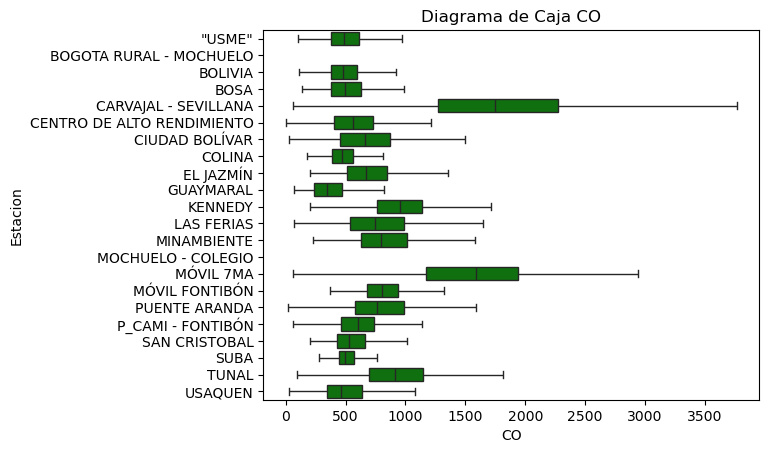

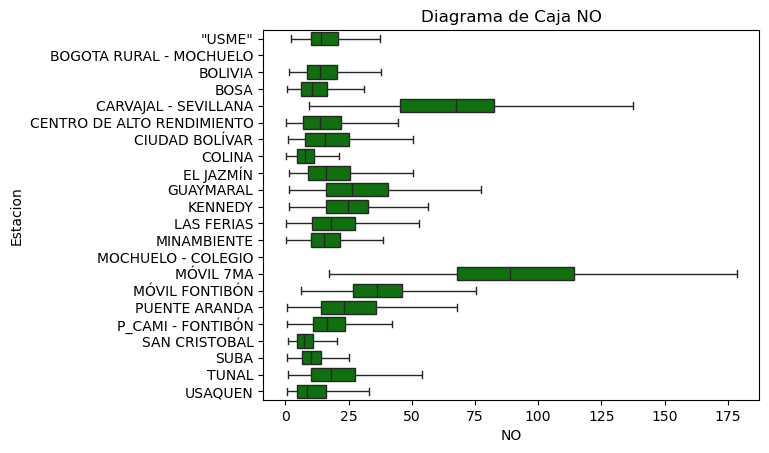

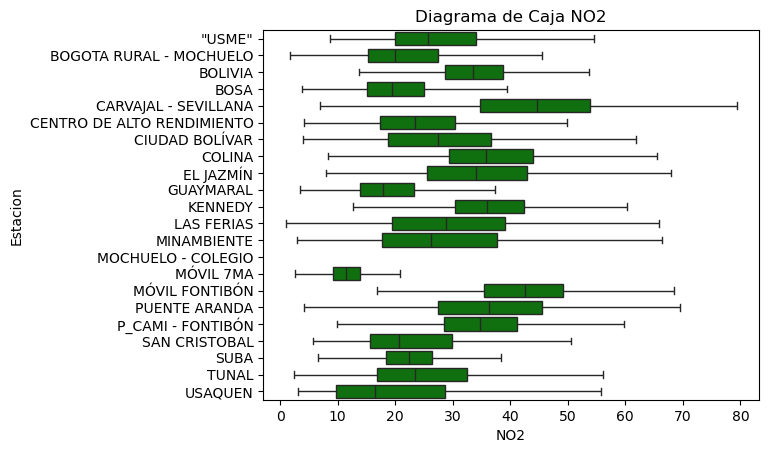

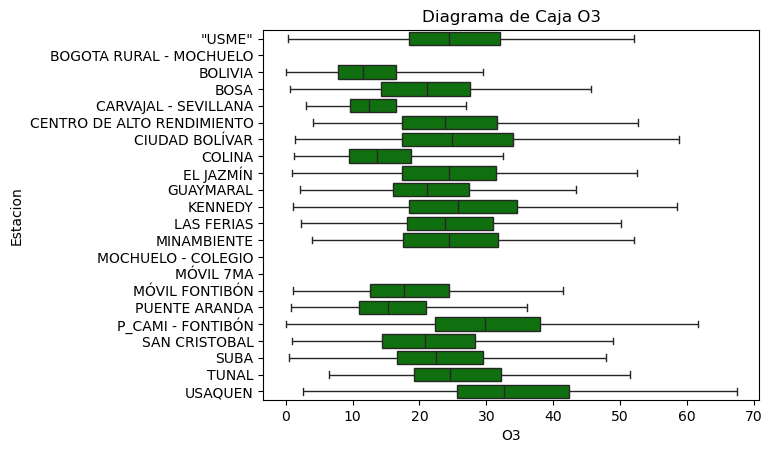

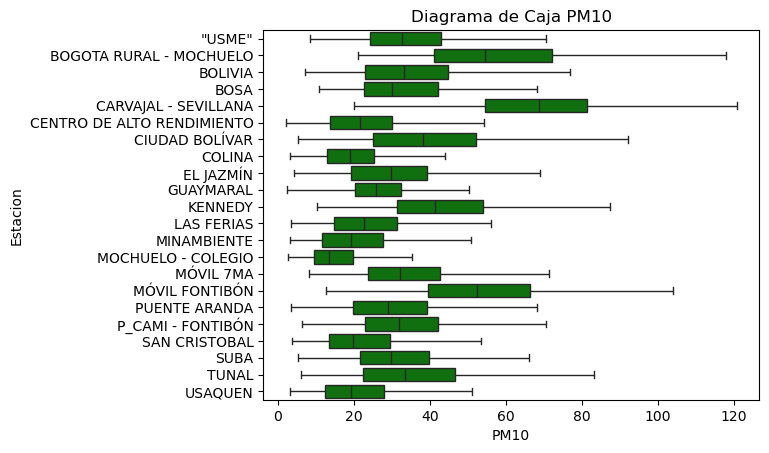

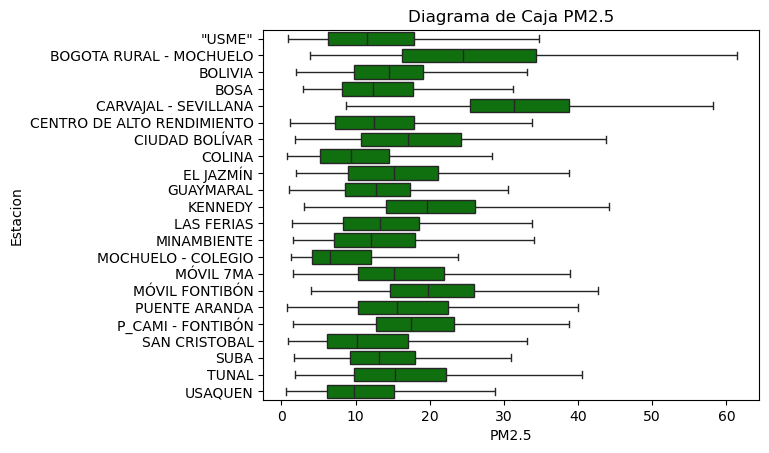

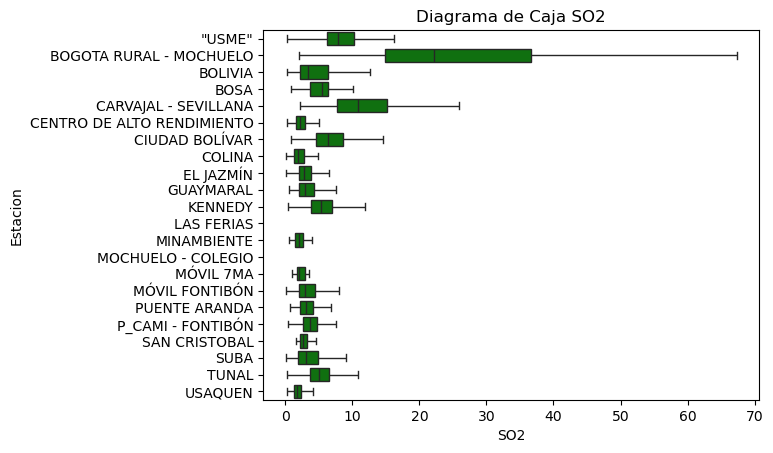

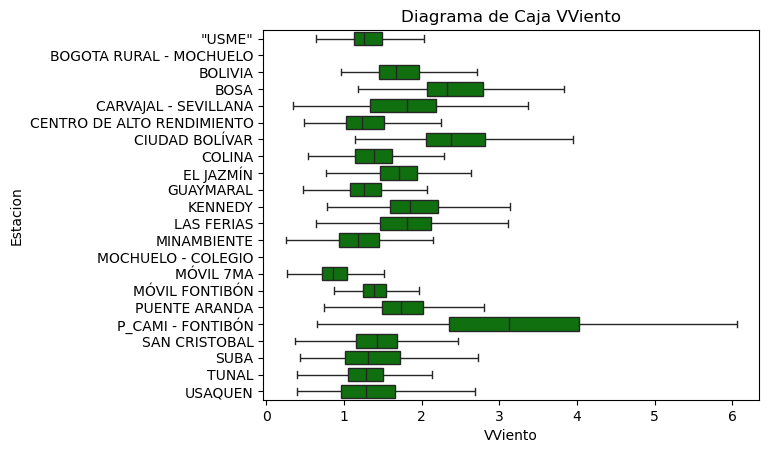

In [29]:
for var in Var:
    ax = sns.boxplot(data=datos, x=var, y=At.est,  orient="h", color="g",  showfliers=False )
    ax.set_title(f"Diagrama de Caja {var}")
    plt.show()

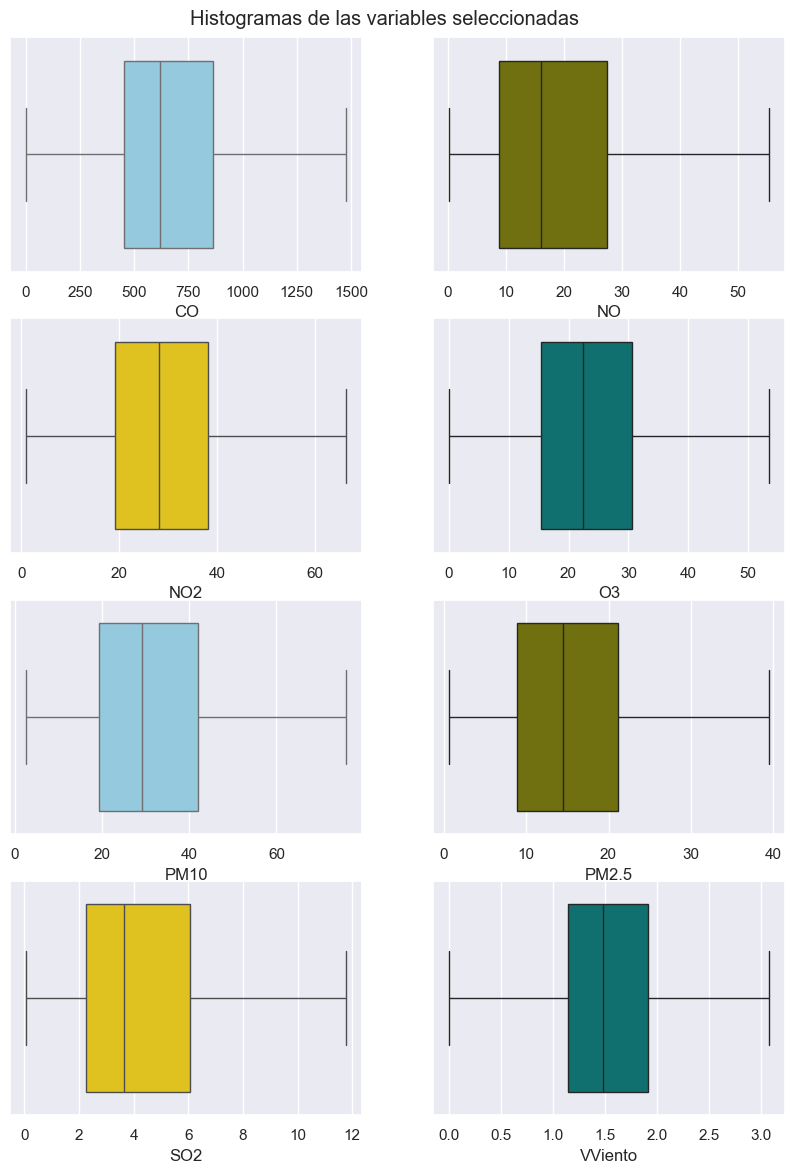

In [76]:
sns.set_theme(style="darkgrid")

fig1, axs1 = plt.subplots(4, 2, figsize=(10, 14))
colores = ("skyblue", "olive", "gold", "teal", "skyblue", "olive", "gold", "teal")

def crear_ejes(dim1, dim2):
    for i in range(dim1):
        for j in range(dim2):
            yield (i, j)

for var, color,  coord in zip (Var, colores, crear_ejes(4, 2)):
    eje = axs1[*coord]
    sns.boxplot(data=datos, x=var,  orient="h", color=color, showfliers=False, ax=eje )


fig1.suptitle("Histogramas de las variables seleccionadas", y=0.9)
plt.show()

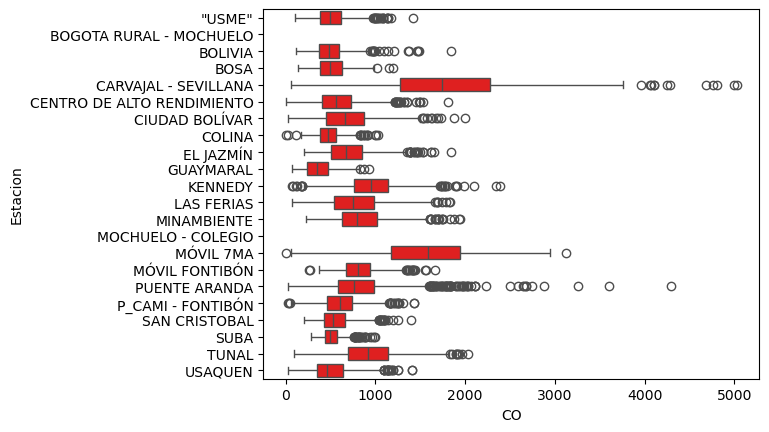

In [30]:
sns.boxplot(data=datos, x=At.co, y=At.est,  orient="h", color="r")
plt.show()

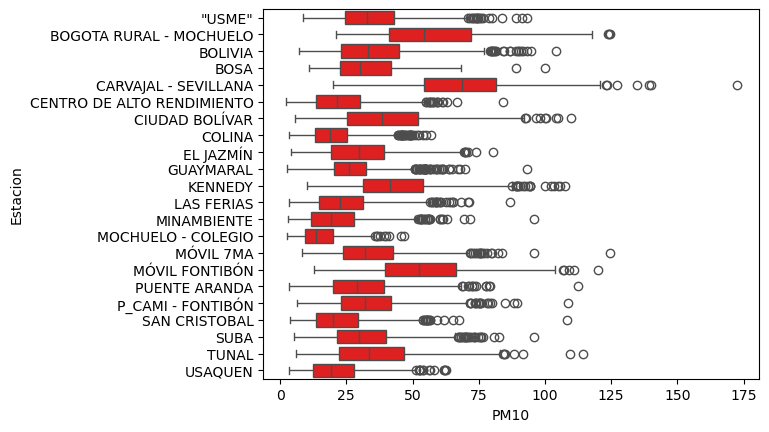

In [31]:
sns.boxplot(data=datos, x=At.pm10, y=At.est,  orient="h", color="r")
plt.show()

# 2. Análisis Bidimensional e Inferencial.

## 1. Dispersion de pares

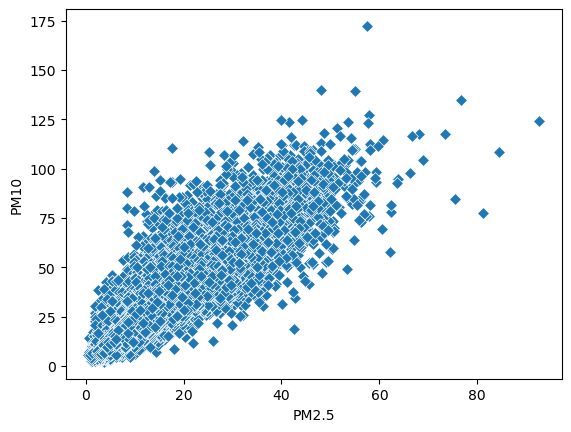

In [62]:
sns.scatterplot(datos, x=Var.pm2, y=Var.pm10, marker="D")
plt.show()

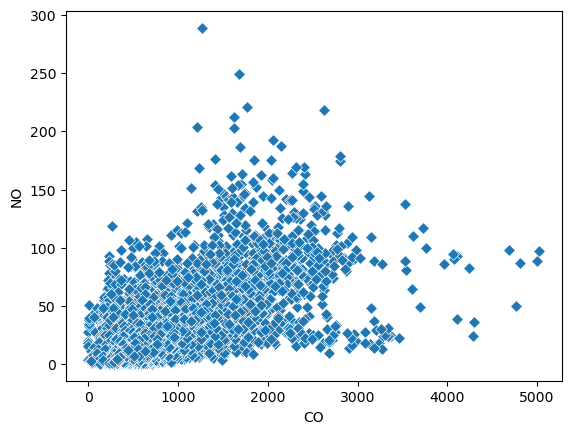

In [14]:
sns.scatterplot(datos, x=Var.co, y=Var.no, marker="D")
plt.show()

C:\Users\frajg\miniconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


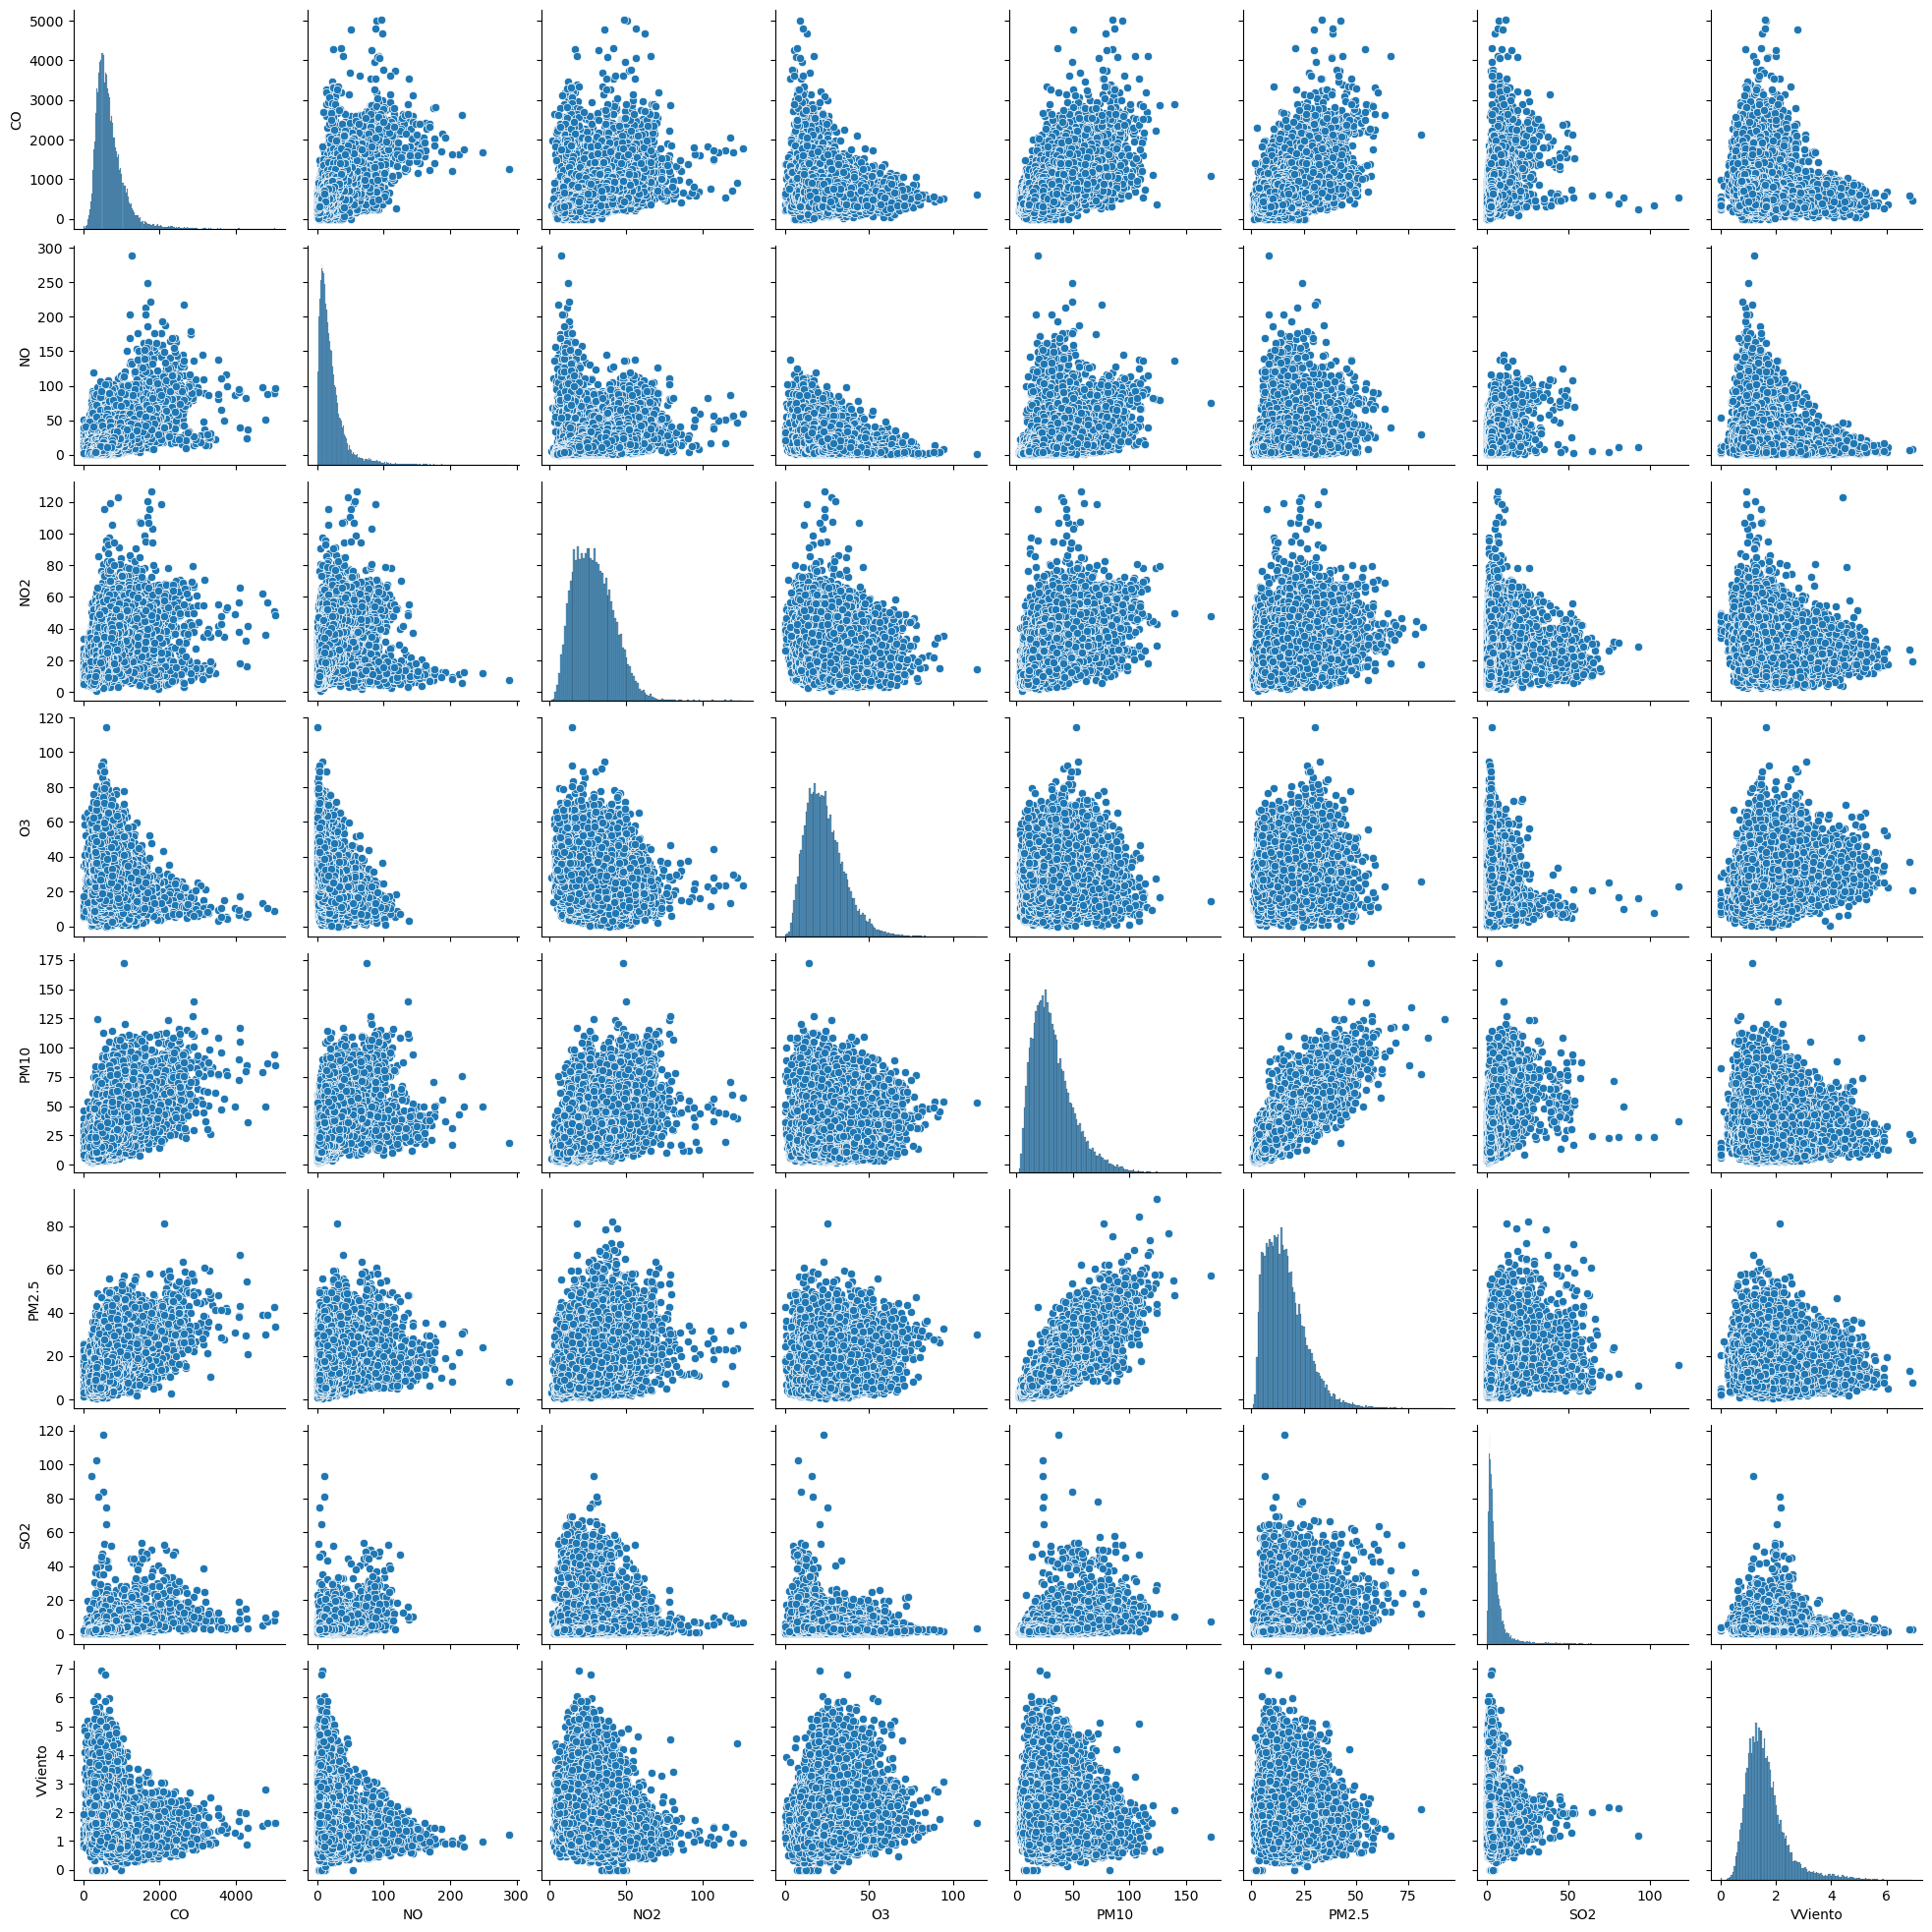

In [30]:
sns.pairplot(datos[[var for var in Var]])
plt.show()

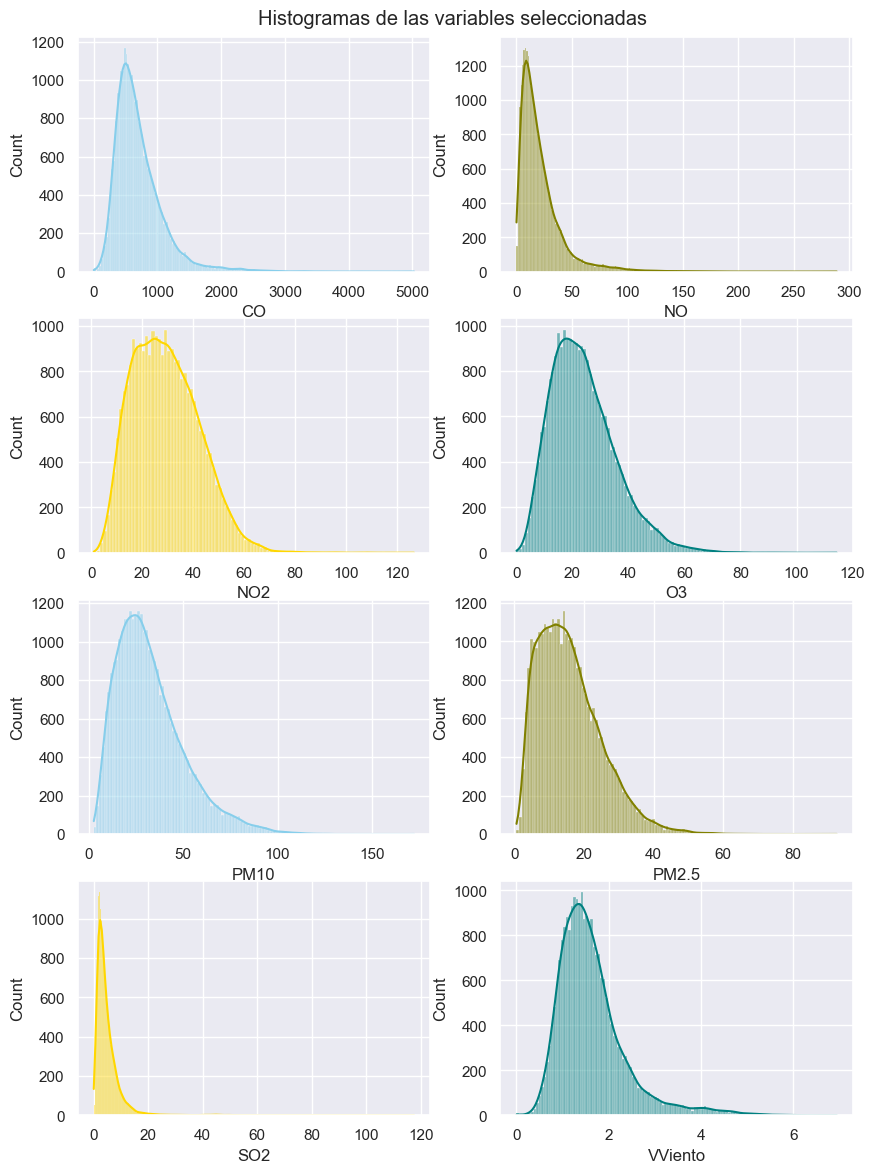

In [72]:
sns.set_theme(style="darkgrid")

fig2, axs2 = plt.subplots(4, 2, figsize=(10, 14))

colores = ("skyblue", "olive", "gold", "teal", "skyblue", "olive", "gold", "teal")

def crear_ejes(dim1, dim2):
    for i in range(dim1):
        for j in range(dim2):
            yield (i, j)

for var, color, coord in zip (Var, colores, crear_ejes(4, 2)):
    eje = axs2[*coord]
    sns.histplot(data=datos, x=var, kde=True, color=color, ax=eje)

fig2.suptitle("Histogramas de las variables seleccionadas", y=0.9)
plt.show()

In [41]:
for var, coord in zip (Var, crear_ejes()):
    print(var)
    print(ejes)

CO
<function ejes at 0x0000020FFB2A0040>
NO
<function ejes at 0x0000020FFB2A0040>
NO2
<function ejes at 0x0000020FFB2A0040>
O3
<function ejes at 0x0000020FFB2A0040>


In [42]:
for coord in crear_ejes():
    print(coord)

(0, 0)
(0, 1)
(1, 0)
(1, 1)


### Analisis de tendencias

## 2. Correlaciones Lineales

El siguiente fragmento de codigo calcula los coeficientes de correlación de pearson, y los valores *P* de la prueba de correlación asociada al mismo tiempoo.
Se hacen pares de las variables numericas en estudio secuencialmente, y toda la informacion se consigna en dos DataFrames: uno llamado  `corr` que contiene
los coeficientes, y otro llamado `valores_p` que contiene los valores p de las pruebas estadisticas.

In [77]:
variables = datos[[Var.co, Var.pm2, Var.pm10, Var.no, Var.no2, Var.o3]].dropna()


corr = pd.DataFrame(index=variables.columns, columns=variables.columns)

valores_p = corr.copy()

for variable_1 in variables.columns:
    coefs = []
    p_valores = []
 
    for variable_2 in variables.columns:
        coef, p_valor = pearsonr(variables[variable_1], variables[variable_2])
        coefs.append(coef)
        p_valores.append(p_valor)

    corr[variable_1] = coefs
    valores_p[variable_1] = p_valores

In [76]:
datos[[Var.co, Var.pm2, Var.pm10, Var.no, Var.no2, Var.o3]].dropna()

,CO,PM2.5,PM10,NO,NO2,O3
0,395.945,7.680,25.804,12.628,23.803,33.730
1,413.160,12.557,32.312,27.557,31.497,23.134
2,486.582,14.183,27.337,12.526,25.299,30.812
3,343.470,7.638,10.058,7.814,20.943,33.951
4,290.995,11.629,24.467,12.245,25.213,38.872
...,...,...,...,...,...,...
81537,768.228,19.273,54.061,17.323,37.142,29.027
81538,718.425,17.375,35.312,10.747,34.051,45.469
81539,628.741,17.708,35.870,11.544,24.719,38.913
81540,333.452,11.130,19.970,3.593,12.356,48.633


### Coeficientes de Correlación

<Axes: title={'center': 'Coeficientes Pearson'}>

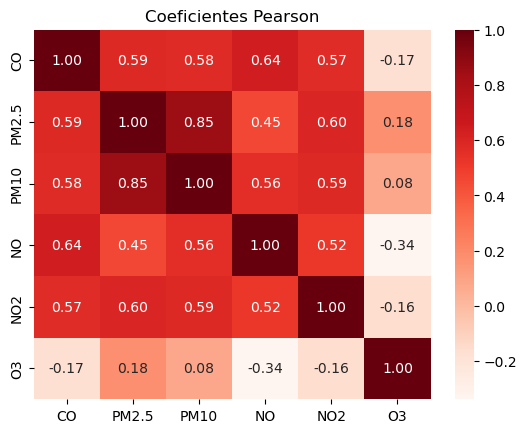

In [78]:
heatmap(corr, "Coeficientes Pearson")

### Valores P de las pruebas estadiscas de correlación

<Axes: title={'center': 'Valores P'}>

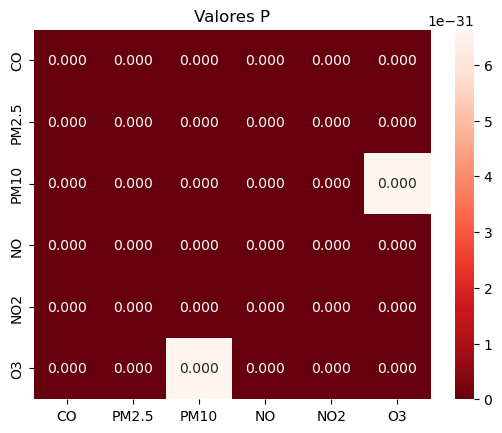

In [79]:
heatmap(valores_p, "Valores P", formato=".3f", mapa="Reds_r")

### Analisis Sobre las correlaciones:

In [108]:
muestras_puntaje = grupos_lealtad[Num.puntaje_promedio.value].apply(np.array)
display(muestras_puntaje)
resultados = f_oneway(*muestras_puntaje) 
mostrar_anova(resultados)

Customer_Loyalty_Status
Gold       [3.59, 4.14, 4.12, 4.31, 3.81, 4.39, 4.79, 4.6...
Regular    [4.31, 3.77, 4.41, 4.69, 4.95, 4.95, 3.97, 3.6...
Silver     [4.47, 4.06, 3.99, 3.51, 3.74, 3.85, 4.22, 4.5...
Name: Average_Ratings, dtype: object

Valor F: 2.314
Valor P: 0.099


# Estandarización de las cantidades

### Estandarización de las variables

Para la comparación de la variabilidad de las variables, se realizó una estandarización de las siguientes variables: *cantidad de personas con acceso internet*, *poblacion*, *indice*: Esto por medio de la clase `StandardScaler`. Despues se realizó los diagramas de caja respectivos para comparar la distribución de las variables numericas.

In [90]:
# usar columnstransformer para trasnformar las columnas necesarias unicamente
datos.columns = datos.columns.astype(str)

variables = [var.value for var in Var]

prep = ColumnTransformer([
    ("escalamiento", StandardScaler(), variables ),
    ],
    remainder='drop' )

display(prep)

#construir el dataframe necesario
datos_std = pd.DataFrame(prep.fit_transform(datos[variables]), columns=variables )


ColumnTransformer(transformers=[('escalamiento', StandardScaler(),
                                 ['CO', 'NO', 'NO2', 'O3', 'PM10', 'PM2.5',
                                  'SO2', 'VViento'])])

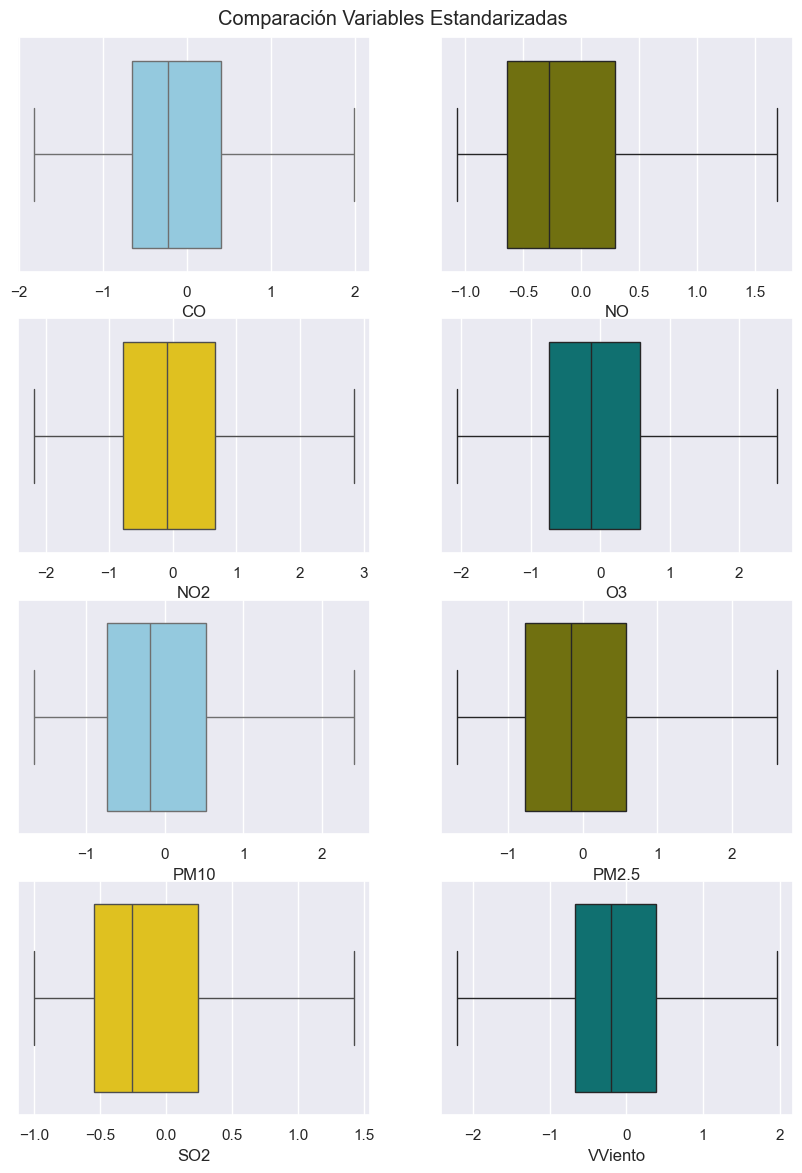

In [96]:
fig3, axs3 = plt.subplots(4, 2, figsize=(10, 14))

colores = ("skyblue", "olive", "gold", "teal", "skyblue", "olive", "gold", "teal")

for var, color, coord in zip (Var, colores, crear_ejes(4, 2)):
    eje = axs3[*coord]
   
    sns.boxplot(data=datos_std, x=var.value, color=color, showfliers=False, ax=eje)


fig3.suptitle("Comparación Variables Estandarizadas", y=0.9)
plt.show()

In [87]:
 datos_std

,0,1,2,3,4,5,6,7
0,-0.798,-0.449,-0.424,0.841,-0.373,-0.903,1.811,-0.432
1,-0.754,0.300,0.167,-0.072,-0.012,-0.366,0.751,-0.109
2,-0.565,-0.454,-0.309,0.590,-0.288,-0.187,1.166,-0.126
3,-0.934,-0.690,-0.644,0.860,-1.244,-0.907,0.433,-0.171
4,-1.069,-0.468,-0.316,1.285,-0.447,-0.468,0.648,-0.041
...,...,...,...,...,...,...,...,...
30873,NaN,NaN,NaN,NaN,-0.599,-0.455,NaN,-0.036
30874,NaN,NaN,NaN,NaN,-0.219,-0.368,NaN,-0.403
30875,NaN,NaN,NaN,NaN,-0.219,-0.533,NaN,-0.285
30876,NaN,NaN,NaN,NaN,-0.184,-0.244,NaN,-0.737


# Referencias

- Kane, F. (2017). Hands-On Data Science and Python Machine Learning. Packt
Publishing.

- Rubio, M. (2019). Estadística con aplicaciones en R. Utadeo.

- Samuels, M., Witmer, J., & Shaffner, A. (2012). Fundamentos de Estadística Para Las Ciencias de la Vida (4th ed.). Pearson.

